In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict
from pathlib import Path
import sys, h5py


In [18]:
COMP6_dir = Path('/storage/users/shuhao/source_data/COMP6')
save_to = Path('/storage/users/shuhao/processed_COMP6')

for f in COMP6_dir.rglob('*.h5'):
    to_npz = defaultdict(list)
    
    with h5py.File(f, 'r') as db:
        max_mol_size = 0
        t = list(db.keys())[0]
        for mol in db[t]:
            group = db[t][mol]
            e = np.array(group['energies'])
            gsize = e.shape[0]
            mol_size = len(group['species'])
            max_mol_size = max(max_mol_size, mol_size)
            to_npz['energy'].append(e)
            to_npz['coord'].append(np.array(group['coordinates']))
            z = species2numbers(np.array(group['species']).astype(str)).reshape(1,-1).repeat(gsize, axis=0)
            to_npz['numbers'].append(z)
            to_npz['mol_name'].append(np.array([mol]*gsize))
            to_npz['forces'].append(np.array(group['forces']))

    to_npz['numbers'] = [pad_Z(z, max_mol_size) for z in to_npz['numbers']]
    to_npz['coord'] = [pad_R(r, max_mol_size) for r in to_npz['coord']]
    to_npz['forces'] = [pad_R(f, max_mol_size) for f in to_npz['forces']]

    for k,v in to_npz.items():
        to_npz[k] = np.concatenate(v)

    np.savez(save_to / f'{f.stem}.npz', **to_npz)


"for f in COMP6_dir.rglob('*.h5'):\n    to_npz = defaultdict(list)\n    \n    with h5py.File(f, 'r') as db:\n        max_mol_size = 0\n        t = list(db.keys())[0]\n        for mol in db[t]:\n            group = db[t][mol]\n            e = np.array(group['energies'])\n            gsize = e.shape[0]\n            mol_size = len(group['species'])\n            max_mol_size = max(max_mol_size, mol_size)\n            to_npz['energy'].append(e)\n            to_npz['coord'].append(np.array(group['coordinates']))\n            z = species2numbers(np.array(group['species']).astype(str)).reshape(1,-1).repeat(gsize, axis=0)\n            to_npz['numbers'].append(z)\n            to_npz['mol_name'].append(np.array([mol]*gsize))\n            to_npz['forces'].append(np.array(group['forces']))\n\n    to_npz['numbers'] = [pad_Z(z, max_mol_size) for z in to_npz['numbers']]\n    to_npz['coord'] = [pad_R(r, max_mol_size) for r in to_npz['coord']]\n    to_npz['forces'] = [pad_R(f, max_mol_size) for f in to_

In [2]:
import torch
import numpy as np
from pathlib import Path
from utils import *
import pandas as pd
from torchani.units import HARTREE_TO_KCALMOL
from matplotlib import pyplot as plt

In [100]:
#COMP6_PROCESSED_DIR = Path('/storage/users/shuhao/processed_COMP6')
#SELECTED_SUBSET = ['gdb11_07_test500', 'gdb11_08_test500', 'gdb13_13_test1000', 'gdb13_12_test1000', 'gdb11_11_test500', 'tripeptide_full',
#                   'gdb11_10_test500', 'drugbank_testset', 'ani_md_bench', 's66x8_wb97x6-31gd', 'gdb11_09_test500']

COMP6_id_map = pd.read_csv('public_COMP6_id_map.csv')
def test_COMP6_b973c(model_list, test_names, working_df=COMP6_id_map, batch_size=2048, device='cpu'):

    loaded_models = []
    for m in model_list:
        m = torch.load(m, map_location=device)
        m.periodic_table_index = True
        m.requires_grad_(False)
        loaded_models.append(m)

    comp6_b973c = h5py.File('/storage/users/shuhao/source_data/comp6_b973c.h5', 'r')
    to_join = {test_name:[] for test_name in test_names+["_id", "b973c.energy", "mol_size"]}
    for g in comp6_b973c:
        group = comp6_b973c[g]
        numbers = group['numbers']
        coord = group['coordinates']
        for model, test_name in zip(loaded_models, test_names):
            pred = batch_inference({'numbers':numbers, 'coord':coord}, model,  batch_size=batch_size, device=device)
            to_join[test_name].append(pred)
        to_join['_id'].append(np.array(group['_id'], dtype=str))
        to_join['b973c.energy'].append(np.array(group['energy']))
        to_join['mol_size'].append(np.array([int(g)]*len(group['energy'])))

    #left join to the working_df on '_id'
    to_join = {k:np.concatenate(v) for k,v in to_join.items()}
    to_join = pd.DataFrame.from_dict(to_join)
    working_df = working_df.merge(to_join, on='_id', how='left')

    return working_df


MODEL_TO_TEST = [
    '/home/shuhaozh/rxn-ani-pub/trained_models/compiled/init_ani1xT5000hartree_lrs1e-3_lrs1e-6_p10_best_compiled.jpt',
    '/home/shuhaozh/rxn-ani-pub/trained_models/compiled/init_ani1x_bbT5000_b24576_lrs1e-3_lrs1e-6_p10_best_compiled.jpt',
    '/home/shuhaozh/rxn-ani-pub/trained_models/compiled/init_ani1x_ani1xT5000+bbT5000_b24576_lrs1e-3_lrs1e-6_p10_best_compiled.jpt',
    '/home/shuhaozh/rxn-ani-pub/trained_models/compiled/init_ani1x_bbT0_b24576_lrs1e-3_lrs1e-6_p10_best_compiled.jpt',
    '/home/shuhaozh/rxn-ani-pub/trained_models/compiled/init_ani1x_bbT0+ani1x_b24576_lrs1e-3_lrs1e-6_p10_best_compiled.jpt',
]

TEST_NAMES = ['ANI1x_b973cT5000', 'b973c_bbT5000', 'ANI1x+bb_b973c_T5000', 'b973c_bbT0', 'ANI1x+bb_b973c_T0']

ret = test_COMP6_b973c(MODEL_TO_TEST, TEST_NAMES, batch_size=2048, device='cuda:1')



100%|██████████| 1/1 [00:00<00:00, 82.63it/s]


In [101]:
#drop rows where b973c.energy is nan
ret = ret.dropna(subset=['b973c.energy'])

In [112]:
ret.to_csv('COMP6_b973c_predictions.csv', index=False)

In [3]:
predictions = pd.read_csv('COMP6_b973c_predictions.csv')
predictions

,subset_name,mol_name,_id,ANI1x_b973cT5000,b973c_bbT5000,ANI1x+bb_b973c_T5000,b973c_bbT0,ANI1x+bb_b973c_T0,b973c.energy,mol_size
0,gdb11_07_test500,mol0000,500b7a9b5f4387328e0bd846,-289.712363,-289.717937,-289.711987,-289.719055,-289.714067,-289.712647,18.0
1,gdb11_07_test500,mol0000,e73a259fcaf7c6a96eb2161e,-289.646875,-289.643597,-289.650094,-289.643738,-289.646886,-289.652223,18.0
2,gdb11_07_test500,mol0000,da7ec7b1f7173771447ebca9,-289.767416,-289.770492,-289.768868,-289.765600,-289.766258,-289.767126,18.0
3,gdb11_07_test500,mol0000,2d23422a1d2936ec162874e6,-289.725758,-289.729927,-289.727953,-289.725738,-289.727079,-289.716881,18.0
4,gdb11_07_test500,mol0000,40572f54fab3d7893f49e170,-289.788937,-289.787596,-289.789630,-289.787443,-289.788160,-289.789726,18.0
...,...,...,...,...,...,...,...,...,...,...
99549,gdb11_09_test500,mol0499,2907193510c1b1c59655f4ed,-455.003097,-455.002680,-455.001944,-454.999925,-454.998406,-455.003282,17.0
99550,gdb11_09_test500,mol0499,2607423e7914141ed15c35fc,-454.910225,-454.912728,-454.917537,-454.908738,-454.916618,-454.917101,17.0
99551,gdb11_09_test500,mol0499,aff615007b09bc8f011e0bd0,-455.023180,-455.027574,-455.025338,-455.024389,-455.021869,-455.027410,17.0
99552,gdb11_09_test500,mol0499,62585afc0adefd3af3a2c664,-454.992679,-454.994304,-454.993574,-454.991541,-454.991591,-454.994263,17.0


In [4]:
# drop rows where subset_name is 'ani_md_bench'
predictions = predictions[predictions['subset_name'] != 'ani_md_bench']
predictions

,subset_name,mol_name,_id,ANI1x_b973cT5000,b973c_bbT5000,ANI1x+bb_b973c_T5000,b973c_bbT0,ANI1x+bb_b973c_T0,b973c.energy,mol_size
0,gdb11_07_test500,mol0000,500b7a9b5f4387328e0bd846,-289.712363,-289.717937,-289.711987,-289.719055,-289.714067,-289.712647,18.0
1,gdb11_07_test500,mol0000,e73a259fcaf7c6a96eb2161e,-289.646875,-289.643597,-289.650094,-289.643738,-289.646886,-289.652223,18.0
2,gdb11_07_test500,mol0000,da7ec7b1f7173771447ebca9,-289.767416,-289.770492,-289.768868,-289.765600,-289.766258,-289.767126,18.0
3,gdb11_07_test500,mol0000,2d23422a1d2936ec162874e6,-289.725758,-289.729927,-289.727953,-289.725738,-289.727079,-289.716881,18.0
4,gdb11_07_test500,mol0000,40572f54fab3d7893f49e170,-289.788937,-289.787596,-289.789630,-289.787443,-289.788160,-289.789726,18.0
...,...,...,...,...,...,...,...,...,...,...
99549,gdb11_09_test500,mol0499,2907193510c1b1c59655f4ed,-455.003097,-455.002680,-455.001944,-454.999925,-454.998406,-455.003282,17.0
99550,gdb11_09_test500,mol0499,2607423e7914141ed15c35fc,-454.910225,-454.912728,-454.917537,-454.908738,-454.916618,-454.917101,17.0
99551,gdb11_09_test500,mol0499,aff615007b09bc8f011e0bd0,-455.023180,-455.027574,-455.025338,-455.024389,-455.021869,-455.027410,17.0
99552,gdb11_09_test500,mol0499,62585afc0adefd3af3a2c664,-454.992679,-454.994304,-454.993574,-454.991541,-454.991591,-454.994263,17.0


In [5]:
error_df = pd.DataFrame()
error_df['subset_name'] = predictions['subset_name']
error_df['mol_name'] = predictions['mol_name']
error_df['mol_size'] = predictions['mol_size']

TEST_NAMES = ['ANI1x_b973cT5000', 'b973c_bbT5000', 'ANI1x+bb_b973c_T5000', 'b973c_bbT0', 'ANI1x+bb_b973c_T0'] 
for test_name in TEST_NAMES:
    error_df[test_name] = (predictions[test_name] - predictions['b973c.energy']) * HARTREE_TO_KCALMOL

error_df

,subset_name,mol_name,mol_size,ANI1x_b973cT5000,b973c_bbT5000,ANI1x+bb_b973c_T5000,b973c_bbT0,ANI1x+bb_b973c_T0
0,gdb11_07_test500,mol0000,18.0,0.178059,-3.319804,0.414031,-4.021066,-0.890998
1,gdb11_07_test500,mol0000,18.0,3.355858,5.412916,1.335675,5.324378,3.348830
2,gdb11_07_test500,mol0000,18.0,-0.181640,-2.112172,-1.092759,0.957726,0.544653
3,gdb11_07_test500,mol0000,18.0,-5.570571,-8.186627,-6.947977,-5.558329,-6.399639
4,gdb11_07_test500,mol0000,18.0,0.494667,1.336374,0.059802,1.432169,0.982699
...,...,...,...,...,...,...,...,...
99549,gdb11_09_test500,mol0499,17.0,0.116461,0.377700,0.839906,2.106616,3.060114
99550,gdb11_09_test500,mol0499,17.0,4.315139,2.744396,-0.273209,5.248352,0.303216
99551,gdb11_09_test500,mol0499,17.0,2.654578,-0.102708,1.300493,1.895904,3.477272
99552,gdb11_09_test500,mol0499,17.0,0.994219,-0.025806,0.432351,1.708342,1.676868


In [6]:
# first, we need to calculate the mean absolute error for each subset
mae_df = error_df.drop(columns=['mol_name', 'mol_size']).groupby('subset_name').apply(lambda x: x.abs().mean())

In [7]:
# second, we need to calculate the mean absolute error of relative energy prediction of each molecule
# relative energy is the energy difference between each conformer and the first conformer available of that molecule in the dataset
# note that we can utilize the fact a2-a1 - (b2-b1) = a2-b2 - (a1-b1)

relative_mae_df = error_df.drop(columns=['mol_size']).copy()
relative_mae_df = relative_mae_df.groupby(['subset_name', 'mol_name']).apply(lambda x: (x - x.iloc[0]).iloc[1:].abs().mean())
relative_mae_df = relative_mae_df.groupby('subset_name').mean()

In [25]:
# third, calculate the mean absolute error of 

,ANI1x_b973cT5000,b973c_bbT5000,ANI1x+bb_b973c_T5000,b973c_bbT0,ANI1x+bb_b973c_T0
subset_name,,,,,
drugbank_testset,3.649426,6.945883,2.639553,14.697890,3.082146
gdb11_07_test500,1.163476,1.336338,0.985830,1.440767,0.980779
gdb11_08_test500,1.396511,1.677343,1.159148,1.964311,1.192328
gdb11_09_test500,1.577338,2.074332,1.364807,2.491100,1.502189
gdb11_10_test500,1.906526,2.483430,1.673886,2.945862,1.915789
gdb11_11_test500,3.086995,4.180375,2.793593,4.855810,2.784854
gdb13_12_test1000,3.375308,4.828697,3.119952,6.438160,3.265950
gdb13_13_test1000,3.651208,5.319246,3.414282,8.245883,3.676637
s66x8_wb97x6-31gd,2.146656,2.658792,1.622222,3.740304,2.191139


In [8]:
title_size = 20
smaller_size = 18
tick_size = 16

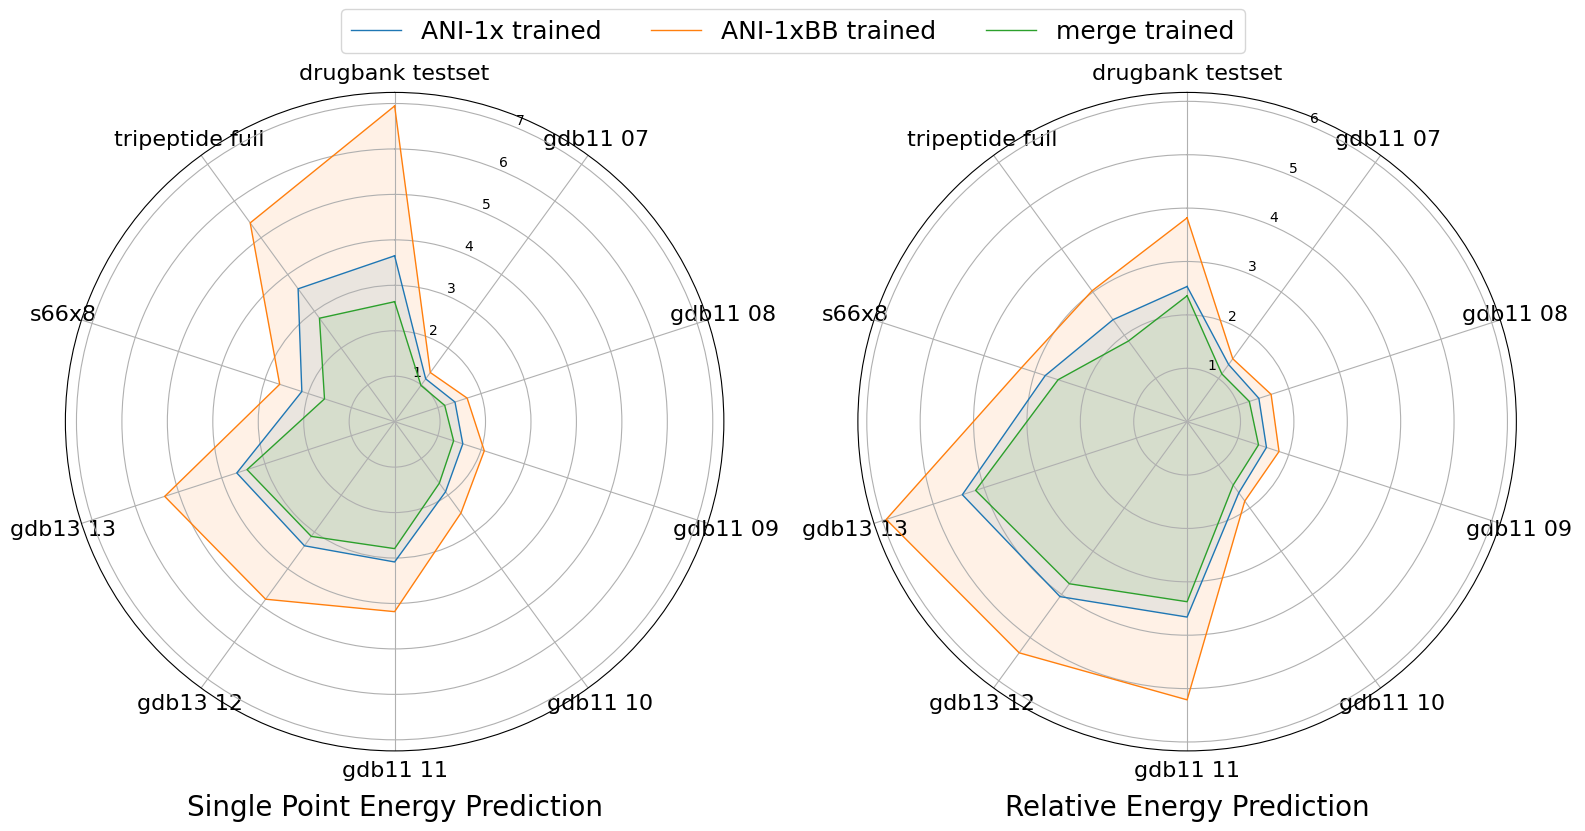

In [10]:
# now, draw a figure with two radar plots to show the mae_df and relative_mae_df
fig, axs = plt.subplots(1, 2, figsize=(16, 8), subplot_kw=dict(polar=True))
labels = list(mae_df.index)
N = len(labels)

testnames_to_plot = ['ANI-1x trained', 'ANI-1xBB trained', 'merge trained']
subset_names_toplot = ['drugbank testset', 'gdb11 07 ', 'gdb11 08 ', 'gdb11 09', 'gdb11 10', 
                       'gdb11 11', 'gdb13 12', 'gdb13 13', 's66x8', 'tripeptide full']
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]

for i, (df, title) in enumerate(zip([mae_df, relative_mae_df], ['Single Point Energy Prediction', 'Relative Energy Prediction'])):
    ax = axs[i]
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    #set labels for each axis
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(subset_names_toplot, size=tick_size)

    error_values = df.values.T
    error_values = error_values[:3]
    for j, (testname, error) in enumerate(zip(testnames_to_plot, error_values)):
        values = np.concatenate([error, error[:1]])
        ax.plot(angles, values, linewidth=1, linestyle='solid', label=testname)
        ax.fill(angles, values, alpha=0.1)

    # add subplot title
    ax.set_title(title, size=title_size, y=-0.11)

# add legend relative to the figure
fig.legend(testnames_to_plot, bbox_to_anchor=(0.5, 1.05), loc='upper center', ncol=3, fontsize=smaller_size)
plt.tight_layout()
plt.show()